In [1]:
from scipy.io import mmread
import pandas as pd
import anndata
from tqdm.notebook import tqdm
import numpy as np
from numba import njit
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import gc

## Read Variant Calling Data

In [6]:
NUM_EMBRYOS = 3
CALLS_SAVE_PATH = 'data/calls_2022_07_06.h5ad'
READS_SAVE_PATH = 'data/reads_2022_07_06.h5ad'

In [8]:
variants_joined = anndata.read_h5ad(CALLS_SAVE_PATH)
reads_joined = anndata.read_h5ad(READS_SAVE_PATH)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


(array([   0.,   18.,  450., 1018., 1373., 2078., 4207., 3540., 2184.,
        1556., 1115.,  974.,  817.,  780.,  663.,  591.,  560.,  516.,
         439.,  468.,  470.,  390.,  434.,  391.,  435.,  379.,  388.,
         385.,  368.,  373.,  332.,  315.,  322.,  346.,  310.,  312.,
         284.,  280.,  246.,  262.,  229.,  226.,  203.,  226.,  198.,
         219.,  214.,  203.,  154.,  201.,  178.,  147.,  157.,  160.,
         150.,  144.,  133.,  137.,  120.,  121.,  101.,  106.,  125.,
          96.,  104.,  110.,  109.,   84.,   82.,   76.,   97.,   82.,
          84.,   85.,   74.,   68.,   77.,   65.,   53.,   83.,   59.,
          79.,   67.,   61.,   80.,   67.,   62.,   49.,   52.,   51.,
          66.,   40.,   50.,   50.,   40.,   49.,   44.,   40.,   50.]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3

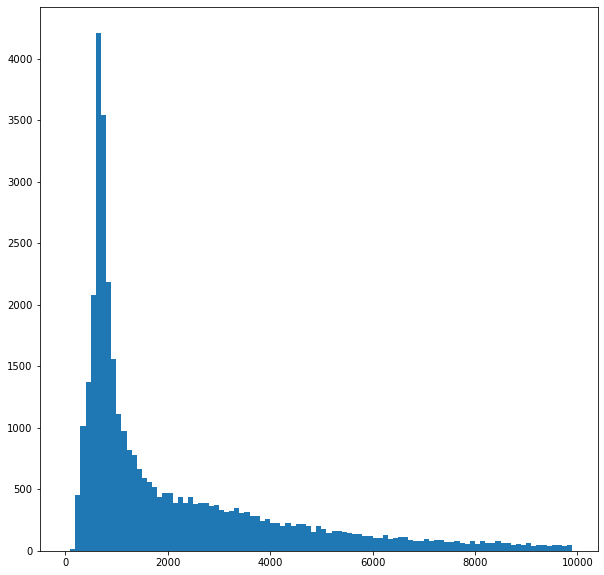

In [10]:
plt.figure(figsize=(10, 10))

reads_sum = reads_joined.X.sum(axis=1)
plt.hist(reads_sum, bins=range(0, 10000, 100))

## Plot Diagnostics for Variant Calling

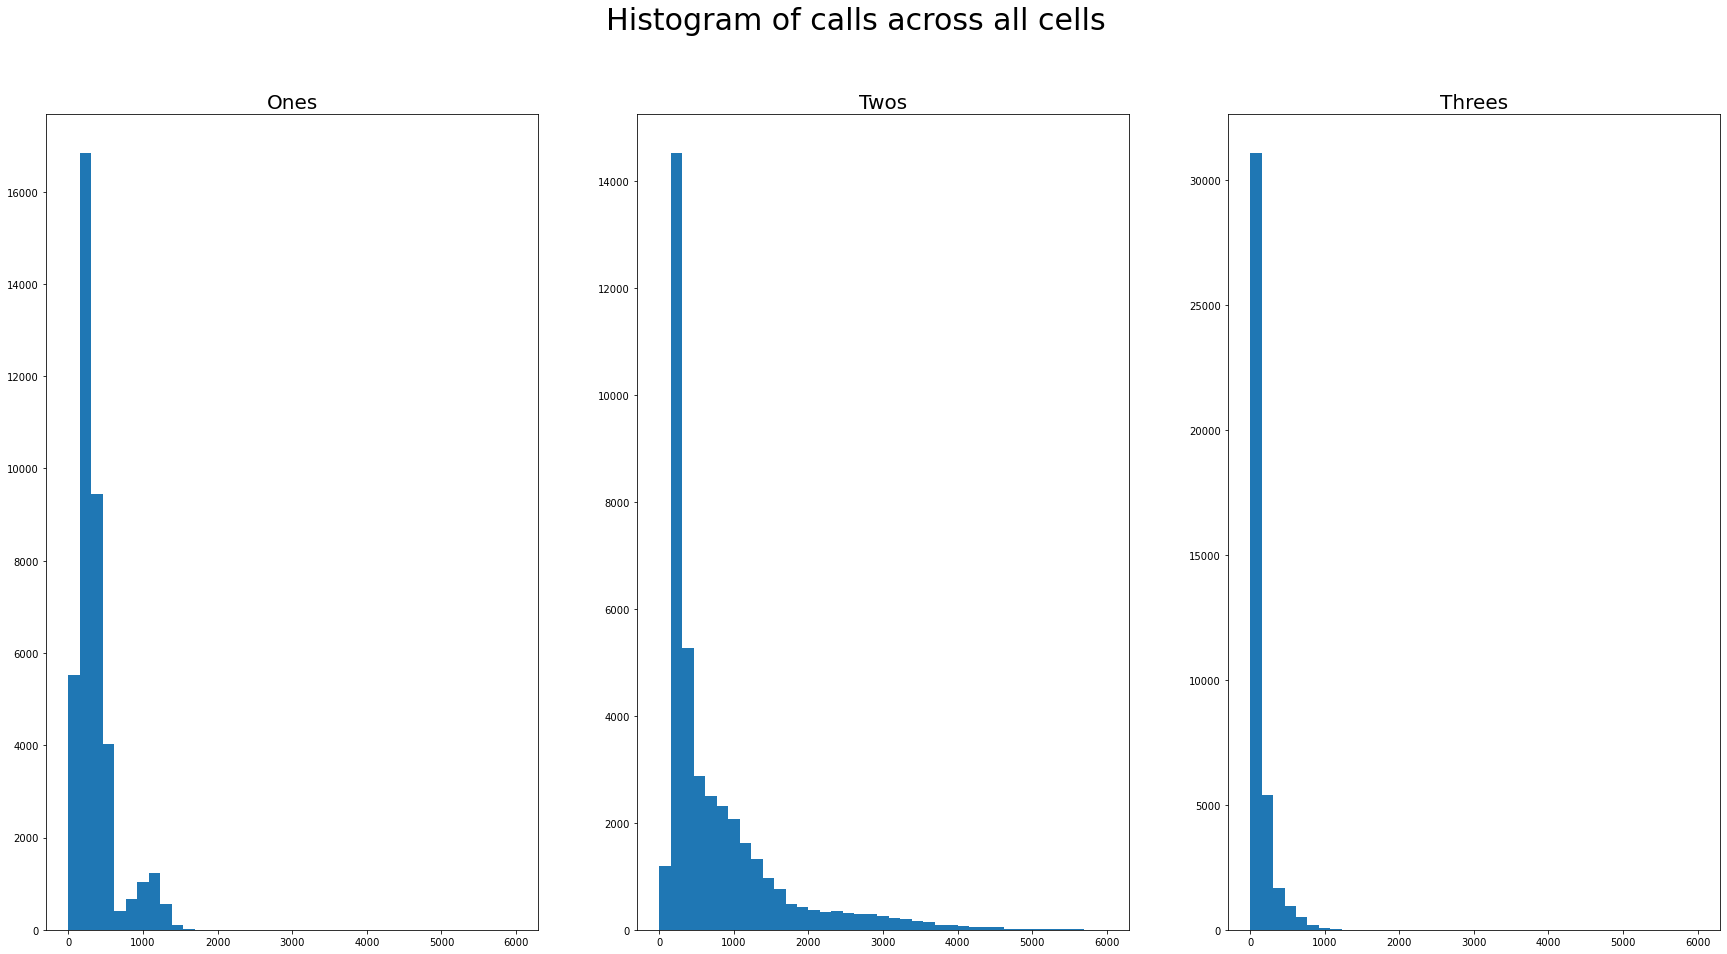

In [6]:
# Plot the counts of each call
threes = np.sum(variants_joined.X == 3, axis=1)
twos = np.sum(variants_joined.X == 2, axis=1)
ones = np.sum(variants_joined.X == 1, axis=1)

plt.figure(figsize=(30, 15))

plt.subplot(131)
plt.title('Ones', fontsize=20)
plt.hist(ones, bins=np.linspace(0, 6000, 40))

plt.subplot(132)
plt.title('Twos', fontsize=20)
plt.hist(twos, bins=np.linspace(0, 6000, 40))

plt.subplot(133)
plt.title('Threes', fontsize=20)
plt.hist(threes, bins=np.linspace(0, 6000, 40))

plt.suptitle('Histogram of calls across all cells', fontsize=30)

plt.show()

(array([24332.,  1668.,   640.,   346.,   210.,    91.,    33.,    62.,
           54.,    26.]),
 array([    0. ,  3981.6,  7963.2, 11944.8, 15926.4, 19908. , 23889.6,
        27871.2, 31852.8, 35834.4, 39816. ]),
 [<matplotlib.patches.Polygon at 0x7f3fc7422410>])

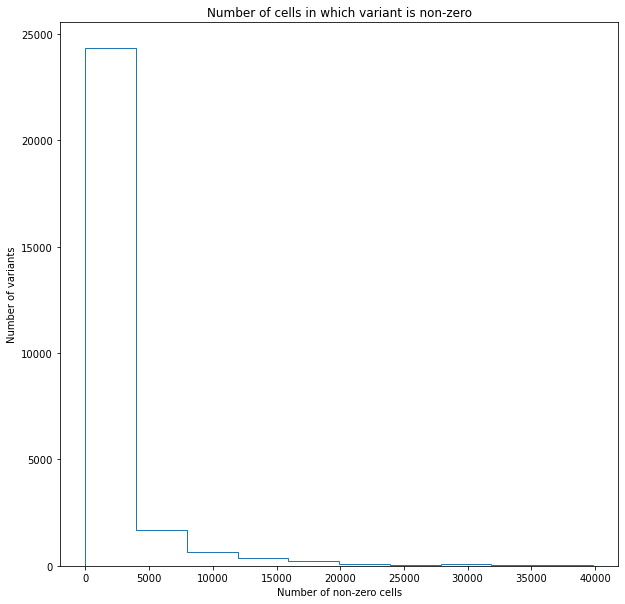

In [7]:
plt.figure(figsize=(10, 10))

plt.title('Number of cells in which variant is non-zero')
plt.ylabel('Number of variants')
plt.xlabel('Number of non-zero cells')

variant_sums = np.array((variants_joined.X > 0).sum(axis=0))
plt.hist(variant_sums, histtype='step')

(0.0, 15.0)

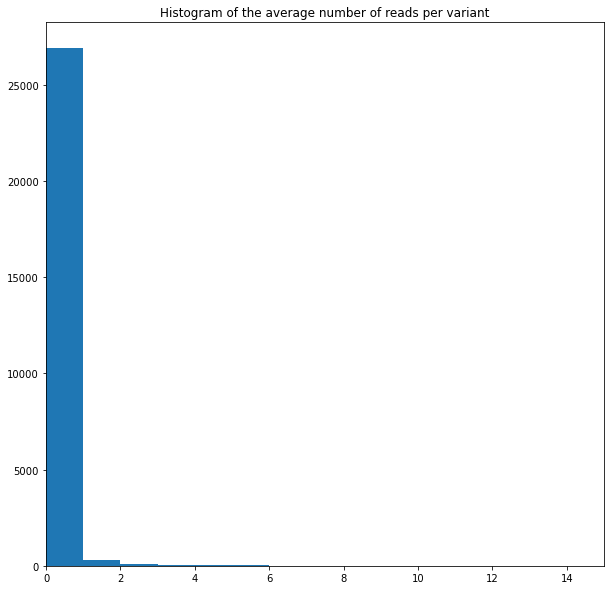

In [13]:
# Make histogram of reads across all cells
plt.figure(figsize=(10, 10))

plt.title('Histogram of the average number of reads per variant')

var_reads_sum = reads_joined.X.sum(axis=0)
var_reads_avg = var_reads_sum/reads_joined.shape[0]

plt.hist(var_reads_avg, bins=range(0, 15))
plt.xlim(0, 15)

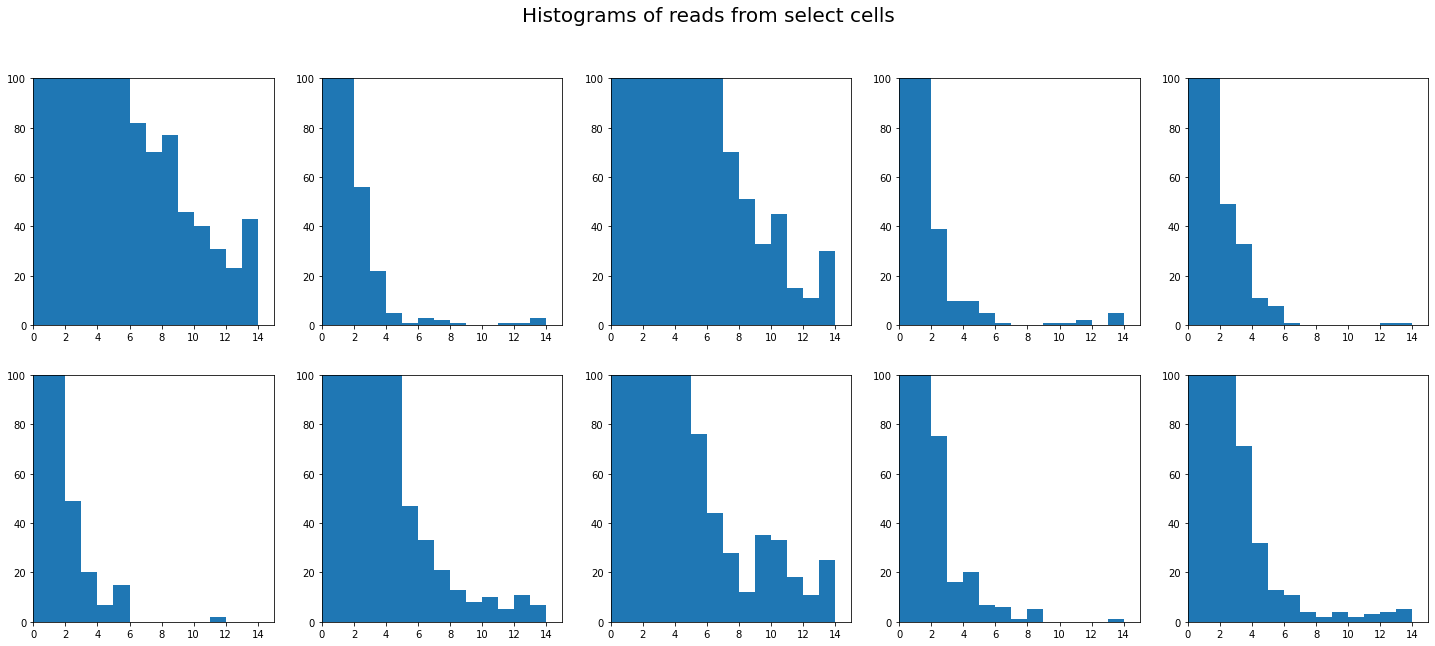

In [7]:
# Now plot the first few cells in the first embryo
plt.figure(figsize=(25, 10))
plt.suptitle('Histograms of reads from select cells', fontsize=20)

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(reads_joined.X[i], bins=range(15))
    plt.xlim(0, 15)
    plt.ylim(0, 100)
    
plt.show()

## Examine Noise Levels Between and Within Embryos

In [8]:
def get_most_common_call(emb):
    counts = []

    for j in tqdm(range(emb.X.shape[1])):
        # Restrict only to cells we have a call for
        calls_for_variant = emb.X[:, j].flatten()
        calls_for_variant = calls_for_variant[calls_for_variant > 0]

        counts.append(np.bincount(calls_for_variant))

    # Find the most common call
    most_common_call = []

    for count in tqdm(counts):
        # If we have any calls for the variant, find the most common one
        if len(count > 0):
            most_common_call.append(np.argmax(count))
        else:
            most_common_call.append(0)

    most_common_call = np.array(most_common_call)
    
    return most_common_call

In [9]:
def find_differences(emb, most_common_call):
    ham_dists = []

    # Now go through each cell and see how many times we deviate from the most common call
    for i in range(emb.shape[0]):
        # Get the profile of detected variants for the cell
        cell = emb.X[i].flatten()
        cell_detected_vars = cell > 0

        ham_dists.append(get_adj_ham_dist_dense(cell, most_common_call))
        
    return ham_dists

In [10]:
def get_adj_ham_dist_dense(cell1, cell2):
    # Find the shared mutations on which we have a call
    shared_inds = (cell1 != 0) & (cell2 != 0)
    num_shared = np.sum(shared_inds)
    
    # Find the number of variants called differently
    dif_call = cell1[shared_inds] != cell2[shared_inds]
    num_dif = np.sum(dif_call)
    
    return num_dif/num_shared

# Computes the adj hamming distance between the given row_num and 
# all cells above the row_num
def compute_dist_row(row_num):
    global mtx
    
    num_cells = mtx.shape[0]
    dists_row = np.zeros(num_cells)
    
    for i in range(row_num + 1, num_cells):
        dists_row[i] = get_adj_ham_dist_dense(mtx[row_num], mtx[i])
        
    return dists_row

# Computes the distance matrix using adjusted hamming distance
# Assumes rows are cells
def compute_adj_hamming_dists(num_cores=70):
    global mtx
    num_cells = mtx.shape[0]
    
    p = Pool(num_cores)
    dists = list(tqdm(p.imap(compute_dist_row, range(num_cells)), total=num_cells))
    p.close()
    
    dists = np.array(dists)
    
    return dists + dists.T

In [11]:
# dists = []
# most_common_calls = []

# for emb_num in variants_joined.obs.embryo.unique():
#     # Find the most common genotype for each embryo
#     emb = variants_joined[variants_joined.obs.embryo == emb_num, :].copy()
    
#     most_common_call = get_most_common_call(emb)
#     most_common_calls.append(most_common_call)
    
#     ham_dists = find_differences(emb, most_common_call)
#     dists.append(ham_dists)

In [12]:
# plt.figure(figsize=(30, 10))

# for i in range(NUM_EMBRYOS):
#     plt.subplot(1, 3, i+1)
#     plt.title(f'Embryo #{i} histogram of adjusted hamming distances', fontsize=20)
#     plt.hist(dists[i])
    
# plt.suptitle('Adjusted Hamming Dists to main embryo genotypes', fontsize=30)

In [13]:
# genotype_dists = []

# for g1 in most_common_calls:
#     dist_g1 = []
    
#     for g2 in most_common_calls:
#         dist_g1.append(get_adj_ham_dist_dense(g1, g2))
        
#     genotype_dists.append(dist_g1)
    
# genotype_dists = np.array(genotype_dists)
# print(f'Dists between embryo genotypes are: \n {genotype_dists}')

## Filter cells by the amount of variants they have good calls for

We will first find only variants called with over a given threshold of reads. Afterwards, we will go cell-by-cell and eliminate cells without enough calls remaining.

In [14]:
THRESHOLD = 20
CALL_CUTOFF = 100

In [15]:
# Set everything below the threshold to 0
above_thresh = reads_joined.X >= THRESHOLD
variants_joined.X[~above_thresh] = 0

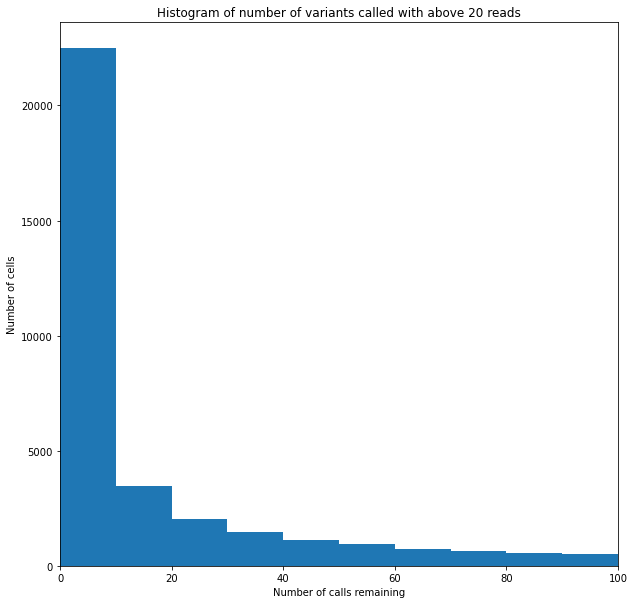

In [16]:
# Make a histogram of how many good calls remain accross the cells
plt.figure(figsize=(10, 10))

plt.title(f'Histogram of number of variants called with above {THRESHOLD} reads')
plt.ylabel('Number of cells')
plt.xlabel('Number of calls remaining')

num_called = np.sum(variants_joined.X, axis=1)
plt.hist(num_called, bins=range(0, 4000, 10))

plt.xlim(0, 100)
plt.show()

In [17]:
variants_joined = variants_joined[num_called >= CALL_CUTOFF, :].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [18]:
variants_joined

AnnData object with n_obs × n_vars = 5827 × 27462
    obs: 'embryo'

## Compute Adjusted Hamming Distances and Cluster

In [19]:
# We have to make the mtx global because partial doesn't work with
# such big data
#mtx = variants_joined.X.toarray()
mtx = variants_joined.X

dists = compute_adj_hamming_dists()
del mtx
del reads_joined

  0%|          | 0/5827 [00:00<?, ?it/s]

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load st

In [20]:
# Plot the distance matrix
plt.figure(figsize=(10, 10))
plt.matshow(dists, fignum=1)
plt.show()

In [21]:
# Get an affinity matrix from out dist matrix
X = np.exp(-dists)
del dists
gc.collect()

In [22]:
X[np.isnan(X)] = 0

In [23]:
spectral_clusters = SpectralClustering(n_clusters=3, affinity='precomputed').fit(X)

In [24]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(variants_joined.obs.embryo, spectral_clusters.labels_)